<a href="https://colab.research.google.com/github/malcolmlett/training-instrumentation-toolkit/blob/main/doc/instrumenting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Instrumentation Toolkit: Instrumentation
If we're going to make it easier to visualise how the training algorithm behaves during training, we need to make sure that it's easy to collect the data needed for visualisation.

While platforms such as TensorFlow and PyTorch are designed for ML engineers and academics to experiment with different things, it is always always easy to do those experiments and have them work reliably and efficiently across many different scenarios.

This notebook explores how I've tried to make the task easier for anyone wanting to instrument their model training.

In [1]:
# Install Training Instrumentation Toolkit
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets

# Run some unit tests
# (no formal packaging in the toolkit as yet, so just a rudimentary manual execution of tests)
import train_instrumentation_test
train_instrumentation_test.run_test_suite()

Cloning into 'training-instrumentation-toolkit'...
remote: Enumerating objects: 1250, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1250 (delta 3), reused 10 (delta 3), pack-reused 1239 (from 1)
Receiving objects: 100% (1250/1250), 84.84 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (752/752), done.
All train_observability_toolkit tests passed.


## Setup
We'll need a model to train and a dataset, so here's a simple binary classification problem against the very commonly used "circles" dataset.

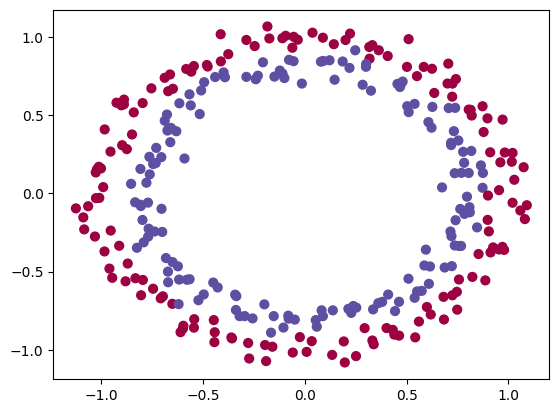

In [2]:
# Using a slightly more elaborate model than needed for such a simple task in order
# to illustrate how dropout and normalization layers appear in visualisations
def binary_classification_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')
  ])
  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  return train_X, train_Y

train_X, train_Y = binary_classification_dataset()
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## A re-usable Custom training loop
If you're using Tensorflow, the standard way to train a model goes something like this:
```python
model = my_model()
model.compile(optimizer='adam', metrics=[...])
history = model.fit(dataset, epochs=100, callbacks=[...])
```

Tensorflow is optimized for training models as rapidly as possible. You can get some useful information about training progress from the loss and other metrics, but that is very high level. You can use callbacks. These have methods that get called at the start and end of each batch update, and at the start and end of each epoch. They're provided the loss and metrics at the time.

You can try to build your own custom callbacks to collect other information about the model at the time. For example, it's not hard to collect information about the model weights and biases at each batch update or each epoch.

However, there is a considerable wealth of useful information that you cannot get access to in this way. For example, you cannot get access to the gradients computed at each update step. For that, you need to write a custom training loop.

That too is not particularly hard for the simple cases. Here's a simple custom training loop that retains the gradients, based in part on TensorFlow's own ["Writing a training loop from scratch"](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) guide:
```python
gradients_history = []
for epoch in range(10):
  for step (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      output = model(x_batch_train, training=True)
      loss = loss_fn(y_batch_train, output)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights)
    gradients_history.append(grads)
```

Things get more complicated if you want to:
* make it auto-graph compatible for maximum training speed
* also collect per-layer outputs
* keep it generic so you can easily use this across many different model architectures and different ways of specifying the dataset

To that end, I provide a pre-written custom training loop within this toolkit. Usage mimics the `model.fit()` pattern as much as possible, with as much as possible of its flexibilites and efficiencies. The main difference is that you replace this:
```python
model.fit(dataset, epochs=10, ....)
```
with this:
```python
tinstr.fit(model, dataset, epochs=10, ....)
```

Here's a concrete example:

In [3]:
model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
history = tinstr.fit(model, dataset, epochs=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6024 - loss: 0.6932 - mse: 0.2487
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5868 - loss: 0.7036 - mse: 0.2539
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6159 - loss: 0.6534 - mse: 0.2313
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6503 - loss: 0.6177 - mse: 0.2136 
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7214 - loss: 0.5944 - mse: 0.2037
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7236 - loss: 0.5896 - mse: 0.2015
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6998 - loss: 0.5786 - mse: 0.1972 
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7254 - loss: 0.5693 - mse: 0.1931
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7477 - loss: 0.5243 - mse: 0.1752 
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7441 - loss: 0.5495 - mse: 0.1851


## The GradientCallback type
The real power of the custom training loop is that it makes significantly more information available to any callbacks supplied. More specifically, it's supports subclasses of an alternative callback type:
* `tinstr.BaseGradientCallback`

That callback defines very similar methods to the standard callback type, but its batch and epoch methods are declared like this:
```python
def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
  pass

def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
  pass

```

Those methods are passed:
* epoch/batch - the usual epoch or batch number
* loss - just the loss metric (on_epoch_end gets the epoch mean, like for a normal callback)
* gradients - the list of gradients used during the most recent update step
* trainable_variables - the list of trainable variables used within the update step (equivalent of calling model.trainable_variables)
* activations - the list of layer outputs for each layer in the model, as they were in the most recent update step
* output_gradients - a list of computed gradients w.r.t. layer outputs

The layer outputs (aka activations) are obtained by the fit() function extracting the layers before it begins training and adding them as outputs to an internal model that effectively wraps the original one.

Thanks to the magic of auto-differentiation, a training loop doesn't normally need to directly obtain output gradients. However, that information can be very useful when troubleshooting. Collecting that does add a little extra computation time, and so the callback implementation has a way to signal to the training loop that it requires that information.

To illustrate, here's a simple custom callback that warns if there's too many zero gradients:

In [13]:
class ZeroGradientWarningCallback(tinstr.BaseGradientCallback):
  def __init__(self):
    super().__init__()

  def on_epoch_begin(self, epoch):
    self.count = 0

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    for grad in gradients:
      self.count += tf.reduce_sum(tf.cast(grad == 0, dtype=tf.int32))

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    if self.count > 100:
      print(f"  {self.count} zero gradients this epoch")

In [14]:
model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[ZeroGradientWarningCallback()])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.4350 - loss: 1.0337 - mse: 0.3481
  104872 zero gradients this epoch
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5043 - loss: 0.8568 - mse: 0.3071
  107955 zero gradients this epoch
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6059 - loss: 0.7121 - mse: 0.2515
  107473 zero gradients this epoch
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5945 - loss: 0.6569 - mse: 0.2349
  110489 zero gradients this epoch
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5954 - loss: 0.6354 - mse: 0.2249
  112008 zero gradients this epoch
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6740 - loss: 0.6338 - mse: 0.2217
  111416 zero gradients this epoch
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6973 - loss: 0.5962 - mse: 0.2062
  114729 zero gradients this epoch
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy

## Standard set of Callbacks
For convenience, the Training Instrumentation Toolkit contains a few out-of-box callbacks. The main ones are these four:

* `VariableHistoryCallback`
  * Collects information about the model variables (weights and biases) during training.
* `GradientHistoryCallback`
  * Collects information about the gradients (w.r.t. to weights and biases) during training.
* `LayerOutputHistoryCallback`
  * Collects information about individual layer outputs during training.
* `LayerOutputGradientHistoryCallback`
  * Collects information about the gradients w.r.t. the layer outputs during training.

By default, each of the above callbacks will collect the following each epoch:
* L2-norm (aka 'euclidean' norm) of each value.
  The norm is actually size-normalized, for easier comparison between layers, which is mathematically equivalent to the RMS (root-mean-square) of the elements in the value.
* percentile distribution of raw per-element values across each value.
* percentile distribution of absolute magnitudes of per-element values across each value.
* model-wide summaries of the above

The callbacks can optionally additionally collect the full raw value tensors. That can be useful if you want to perform your statistical analysis, or you want to use some of the other toolkit functionality that requires raw values. However, it consumes a lot of extra memory, so caution is warned. There is some ability to tweak how much is collected, which I'll discuss later.

For further details see the pydocs within the code.

Some other callbacks provided:
* `HistoryStats`
  * An extended version of the standard `History` callback that collects percentile stats of the loss and metrics over the batches in each epoch. See the _Visualisations_ notebook for where that can be beneficial.
* `LessVerboseProgressLogger`
  * Like the standard in-built progress logger, but more suitable when you're running many tens or hundreds or more epochs. By default, it only outputs status 10 times during training.
* `LearningRateHistoryCallback`
  * An experiment into computing the _implicit learning rate_ tensors that are a result of individual per-element tuning applied by optimizers such as Adam.

## Per-epoch vs Per-step data collection
You're probably use to seeing loss and other metrics being captured each epoch and then plotting that information. But sometimes getting that information at the frequency of each update step can be extremely useful.

That's particularly so when looking at gradients, which are computed anew each update step. It can be even more important when troubleshooting gradient collapse scenarios, which can sometimes play out over just a small handful of update steps.

Each of the four main callbacks support a `per_step` argument to control whether they collect data per-epoch (the default) or per-step. The example visualitation functions automatically honour that.

Here's some examples.

In [8]:
gradients_per_epoch = tinstr.GradientHistoryCallback(per_step=False)  # (this is the default if not specified)
gradients_per_step = tinstr.GradientHistoryCallback(per_step=True)

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[gradients_per_epoch, gradients_per_step])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.4549 - loss: 0.9273 - mse: 0.3227
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5330 - loss: 0.7442 - mse: 0.2681
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5814 - loss: 0.6598 - mse: 0.2349
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6696 - loss: 0.6513 - mse: 0.2301
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6534 - loss: 0.6242 - mse: 0.2189
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6737 - loss: 0.5775 - mse: 0.2009
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6913 - loss: 0.5768 - mse: 0.1990
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6449 - loss: 0.5902 - mse: 0.2071
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7684 - loss: 0.5118 - mse: 0.1699
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7431 - loss: 0.5161 - mse: 0.1734


In [40]:
print("gradients_per_epoch - model-wide:")
print(f"  model_norm_stats: {type(gradients_per_epoch.model_norm_stats)} with shape {gradients_per_epoch.model_norm_stats.shape}")
print(f"  model_magnitude_stats: {type(gradients_per_epoch.model_magnitude_stats)} with shape {gradients_per_epoch.model_magnitude_stats.shape}")
print()
print(f"gradients_per_epoch - across {len(model.variables)} trainable variables of which {len(model.trainable_variables)} are trainable:")
print(f"  value_norms: {type(gradients_per_epoch.value_norms)} of {len(gradients_per_epoch.value_norms)} x {type(gradients_per_epoch.value_norms[0])} with shape {gradients_per_epoch.value_norms[0].shape}")
print(f"  value_stats: {type(gradients_per_epoch.value_stats)} of {len(gradients_per_epoch.value_stats)} x {type(gradients_per_epoch.value_stats[0])} with shape {gradients_per_epoch.value_stats[0].shape}")
print(f"  magnitude_stats: {type(gradients_per_epoch.magnitude_stats)} of {len(gradients_per_epoch.magnitude_stats)} x {type(gradients_per_epoch.magnitude_stats[0])} with shape {gradients_per_epoch.magnitude_stats[0].shape}")
print()
print("magnitude stats for first trainable variable:")
gradients_per_epoch.magnitude_stats[0]

gradients_per_epoch - model-wide:
  model_norm_stats: <class 'pandas.core.frame.DataFrame'> with shape (10, 5)
  model_magnitude_stats: <class 'pandas.core.frame.DataFrame'> with shape (10, 5)

gradients_per_epoch - across 20 trainable variables of which 16 are trainable:
  value_norms: <class 'list'> of 20 x <class 'numpy.ndarray'> with shape (10,)
  value_stats: <class 'list'> of 20 x <class 'pandas.core.frame.DataFrame'> with shape (10, 9)
  magnitude_stats: <class 'list'> of 20 x <class 'pandas.core.frame.DataFrame'> with shape (10, 9)

magnitude stats for first trainable variable:


,0.0,12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0
0,8.292273e-04,0.010689,0.022324,0.032333,0.042280,0.058741,0.073640,0.104289,0.219561
1,6.517023e-05,0.010892,0.021630,0.035350,0.046235,0.059971,0.082792,0.113095,0.223104
2,2.116617e-05,0.008673,0.015905,0.023764,0.033497,0.046661,0.059609,0.077313,0.187879
3,6.826967e-05,0.007187,0.018177,0.025919,0.033201,0.043033,0.057074,0.077767,0.206704
4,6.612390e-08,0.006261,0.014190,0.023368,0.027732,0.035810,0.048516,0.063926,0.159352
5,1.580901e-04,0.008609,0.017153,0.024102,0.030577,0.041768,0.058332,0.082349,0.154742
6,7.548369e-05,0.005142,0.011123,0.019259,0.031769,0.044439,0.052716,0.078909,0.194714
7,4.269695e-05,0.006800,0.014851,0.024822,0.041037,0.051807,0.064970,0.082591,0.162342
8,7.942040e-05,0.006997,0.014418,0.020839,0.026393,0.036118,0.045032,0.062763,0.125746
9,1.991596e-04,0.006240,0.012817,0.019606,0.027762,0.034456,0.043065,0.058895,0.127512


In [41]:
print("gradients_per_step - model-wide:")
print(f"  model_norm_stats: {type(gradients_per_step.model_norm_stats)} with shape {gradients_per_step.model_norm_stats.shape}")
print(f"  model_magnitude_stats: {type(gradients_per_step.model_magnitude_stats)} with shape {gradients_per_step.model_magnitude_stats.shape}")
print()
print(f"gradients_per_step - across {len(model.variables)} trainable variables of which {len(model.trainable_variables)} are trainable:")
print(f"  value_norms: {type(gradients_per_step.value_norms)} of {len(gradients_per_step.value_norms)} x {type(gradients_per_step.value_norms[0])} with shape {gradients_per_step.value_norms[0].shape}")
print(f"  value_stats: {type(gradients_per_step.value_stats)} of {len(gradients_per_step.value_stats)} x {type(gradients_per_step.value_stats[0])} with shape {gradients_per_step.value_stats[0].shape}")
print(f"  magnitude_stats: {type(gradients_per_step.magnitude_stats)} of {len(gradients_per_step.magnitude_stats)} x {type(gradients_per_step.magnitude_stats[0])} with shape {gradients_per_step.magnitude_stats[0].shape}")
print()
print("magnitude stats for first trainable variable:")
gradients_per_step.magnitude_stats[0]

gradients_per_step - model-wide:
  model_norm_stats: <class 'pandas.core.frame.DataFrame'> with shape (100, 5)
  model_magnitude_stats: <class 'pandas.core.frame.DataFrame'> with shape (100, 5)

gradients_per_step - across 20 trainable variables of which 16 are trainable:
  value_norms: <class 'list'> of 20 x <class 'numpy.ndarray'> with shape (100,)
  value_stats: <class 'list'> of 20 x <class 'pandas.core.frame.DataFrame'> with shape (100, 9)
  magnitude_stats: <class 'list'> of 20 x <class 'pandas.core.frame.DataFrame'> with shape (100, 9)

magnitude stats for first trainable variable:


,0.0,12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0
0,0.000022,0.001783,0.005069,0.007639,0.010207,0.013790,0.017113,0.023186,0.042060
1,0.000091,0.002073,0.004687,0.008241,0.011924,0.016629,0.020950,0.026363,0.055715
2,0.000176,0.002708,0.005477,0.008041,0.011606,0.014354,0.018113,0.025423,0.097050
3,0.000079,0.002769,0.005834,0.009109,0.013007,0.017790,0.023099,0.030935,0.074294
4,0.000015,0.002159,0.005604,0.008495,0.011824,0.014594,0.019201,0.024448,0.060859
...,...,...,...,...,...,...,...,...,...
95,0.000003,0.001377,0.002269,0.004346,0.006715,0.008728,0.012638,0.018146,0.046746
96,0.000037,0.001555,0.002861,0.005335,0.007069,0.009459,0.012274,0.019236,0.043047
97,0.000079,0.002823,0.005878,0.008048,0.010264,0.014704,0.019101,0.024904,0.051122
98,0.000014,0.002032,0.003275,0.005382,0.008379,0.010765,0.013658,0.017548,0.040710


The percentile stats dataframes have the percentiles in the column headings.

Hot tip: for a quick plot of the a given stats dataframe, do this:

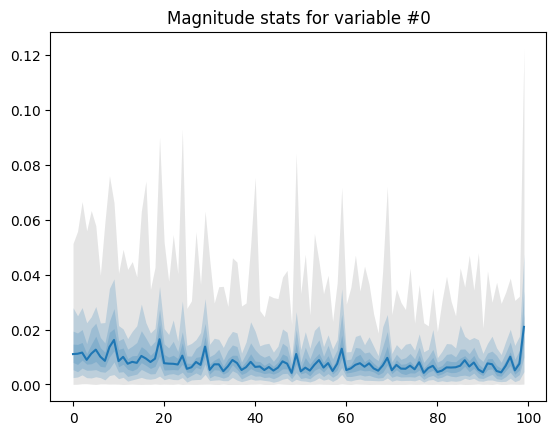

In [9]:
df = gradients_per_step.magnitude_stats[0]
plt.title("Magnitude stats for variable #0")
tinstr._plot_add_quantiles(x=list(range(len(df))), data=df)
plt.show()

## Variable and Layer Indexing
In order to create some consistency between the four main callbacks, and the different options available, all variables and gradients are indexed relative to `model.variables`.

`model.variables` returns the complete set of variables contained within the model. This includes the trainable variables within trainable layers, which itself includes the less obvious trainable variables used by layers such as `BatchNormalisation`. It also includes non-trainable variables. For example, Dropout layers maintain a `seed_generator_state`, and `BatchNormalization` layers include non-trainable `moving_mean` and `moving_variance` in addition to their trainable `gamma` and `beta` parameters.

What does this mean to you?

When looking at the results from the above callbacks, the indexing is always relative to `model.variables`, even when it doesn't collect data for all of those variables. For example, gradients are only available for trainable variables of trainable layers. This means that the gradient variable stats list, for example, is made up of a series something like as follows, with a stats dataframe for each variable for which gradients have been collected, and `None` placeholders for the rest:
```python
[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, None, None, pd.DataFrame, ...]
```

The same always to per-layer data such as layer outputs and layer output gradients. These are always indexed relative to `model.layers`.

Alternatively, the callbacks provide access to the same indexed only by those values that are collected (due to whatever restrictions happen to be in force at the time). These are accessed via:
* `callback.collected_value_norms()`
* `callback.collected_value_stats()`
* `callback.collected_magnitude_stats()`
* `callback.collected_activity_stats()`

The problem is that you don't know which the original variables or layers they relate to now. This is solved via the following method which lists the raw variable indices (relative to model.variables or model.layers accordingly):
* `callback.collected_value_stats_indices`
* `callback.collected_activity_stats_indices`  (will usually have the same result as `collected_value_stats_indices`)

Furthermore, the toolkit includes some functions to ease the indexing conversions in various directions:
* `tinstr.variable_indices_by_layer()`
* `tinstr.trainable_variable_indices_by_layer()`
* `tinstr.variable_indices_to_trainable_variable_indices()`
* `tinstr.trainable_variable_indices_to_variable_indices()`
* `tinstr.layer_indices_by_variable()`
* `tinstr.layer_indices_by_trainable_variable()`

**Visualisations**

A few functions are available for visualising the data collected by the callbacks:
* `tinstr.plot_history_overview(callback_list)`
* `tinstr.plot_train_history(history_callback)`
* `tinstr.plot_value_history(any_callback)`
* `tinstr.plot_activity_history(any_callback)`

For details, see the _Visualisations_ notebook.

Here I'll just show that the visualisation functions honour the `per_step` setting:

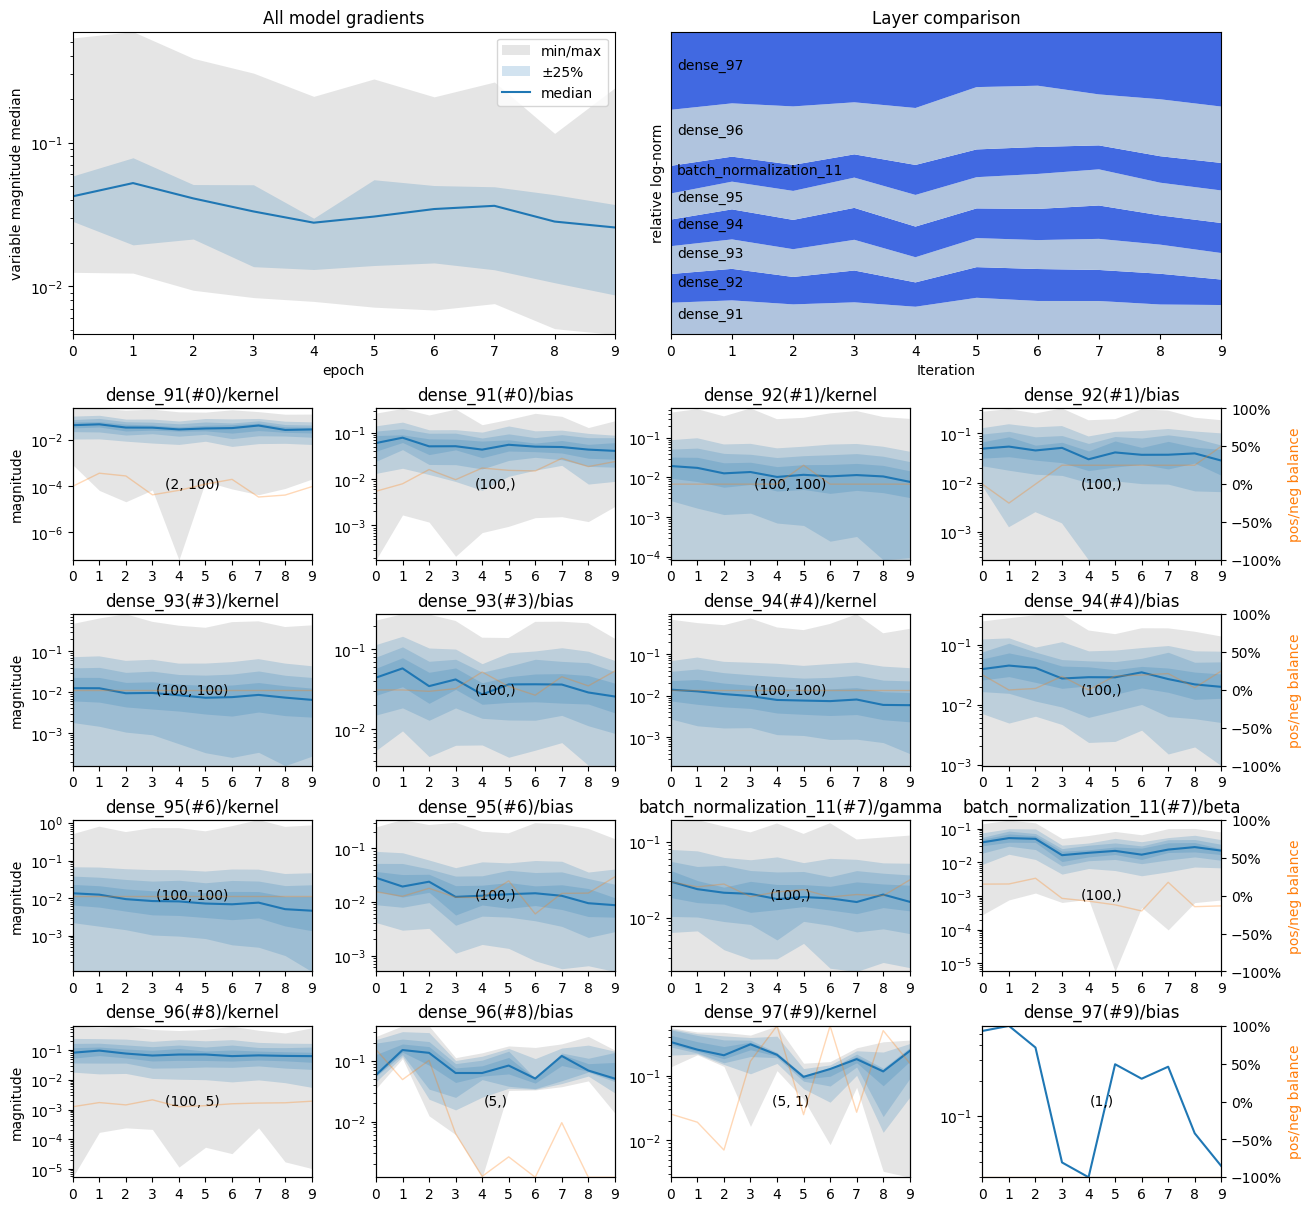

In [42]:
tinstr.plot_value_history(gradients_per_epoch)

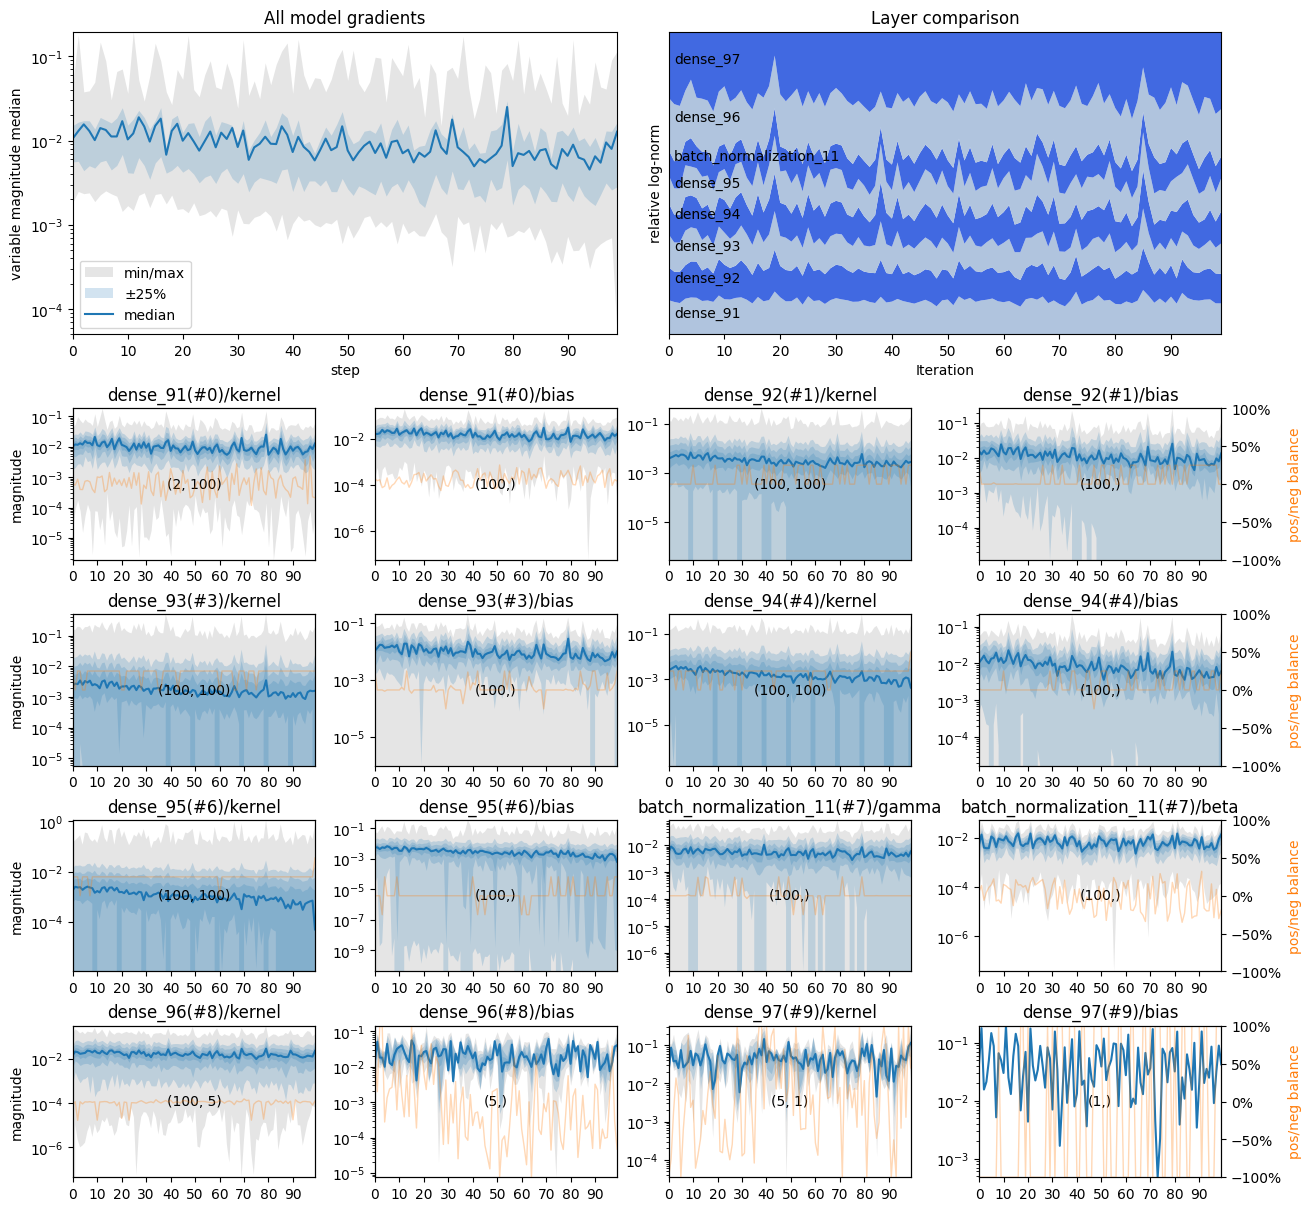

In [43]:
tinstr.plot_value_history(gradients_per_step)

## Performance
Unfortunately, collecting detailed statistics of values is computationally expensive. This means that your training loops can run significantly slower if you use these callbacks. But there are some ways to get the benefit of this extra visibility while minimising the performance impact.

Here's some tips for improving performance:
* for normal training, only run the callbacks that you need, if any at all.
* for normal training, only collect per-epoch (`per_step=False`) data
* for maximum performance, collect only the value norms and disable value stats and activity stats (`value_norms=True, value_stats=False, activity_stats=False`)

As illustration, compare the total training times of the following three training examples:

In [45]:
# baseline
model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)

start = tf.timestamp()
history = tinstr.fit(model, dataset, epochs=100, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 378.03ms/epoch: accuracy: 0.7500  loss: 0.5013  mse: 0.1657  
Epoch    20 - 58.07ms/epoch: accuracy: 0.8233  loss: 0.4187  mse: 0.1333  
Epoch    30 - 78.19ms/epoch: accuracy: 0.8767  loss: 0.3229  mse: 0.0984  
Epoch    40 - 103.72ms/epoch: accuracy: 0.8700  loss: 0.3032  mse: 0.0936  
Epoch    50 - 49.53ms/epoch: accuracy: 0.8567  loss: 0.2962  mse: 0.0945  
Epoch    60 - 50.52ms/epoch: accuracy: 0.9133  loss: 0.2556  mse: 0.0714  
Epoch    70 - 46.72ms/epoch: accuracy: 0.9133  loss: 0.2094  mse: 0.0649  
Epoch    80 - 43.59ms/epoch: accuracy: 0.9100  loss: 0.2098  mse: 0.0652  
Epoch    90 - 42.29ms/epoch: accuracy: 0.9233  loss: 0.1647  mse: 0.0517  
Epoch   100 - 45.18ms/epoch: accuracy: 0.9367  loss: 0.1717  mse: 0.0507  
Total training time: 8.97 secs


In [46]:
# minimal data collection across most informative measurables
gradients = tinstr.GradientHistoryCallback(per_step=False, value_norms=True, value_stats=False, activity_stats=False)
outputs = tinstr.LayerOutputHistoryCallback(per_step=False, value_norms=True, value_stats=False, activity_stats=False)

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)

start = tf.timestamp()
history = tinstr.fit(model, dataset, epochs=100, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), gradients, outputs])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 445.92ms/epoch: accuracy: 0.7100  loss: 0.5367  mse: 0.1809  
Epoch    20 - 160.55ms/epoch: accuracy: 0.7600  loss: 0.4676  mse: 0.1560  
Epoch    30 - 114.57ms/epoch: accuracy: 0.8533  loss: 0.3702  mse: 0.1119  
Epoch    40 - 88.65ms/epoch: accuracy: 0.8933  loss: 0.2811  mse: 0.0851  
Epoch    50 - 89.36ms/epoch: accuracy: 0.8467  loss: 0.2969  mse: 0.0952  
Epoch    60 - 85.80ms/epoch: accuracy: 0.8867  loss: 0.2749  mse: 0.0835  
Epoch    70 - 94.35ms/epoch: accuracy: 0.8833  loss: 0.2660  mse: 0.0825  
Epoch    80 - 95.69ms/epoch: accuracy: 0.9100  loss: 0.2019  mse: 0.0631  
Epoch    90 - 98.58ms/epoch: accuracy: 0.9233  loss: 0.2185  mse: 0.0632  
Epoch   100 - 137.03ms/epoch: accuracy: 0.9400  loss: 0.1859  mse: 0.0519  
Total training time: 14.29 secs


In [47]:
# maximum stats collection across all measurables
variables = tinstr.VariableHistoryCallback(per_step=True)
gradients = tinstr.GradientHistoryCallback(per_step=True)
outputs = tinstr.LayerOutputHistoryCallback(per_step=True)
output_gradients = tinstr.LayerOutputGradientHistoryCallback(per_step=True)

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)

start = tf.timestamp()
history = tinstr.fit(model, dataset, epochs=100, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 2.57s/epoch: accuracy: 0.7800  loss: 0.4833  mse: 0.1569  
Epoch    20 - 748.27ms/epoch: accuracy: 0.8333  loss: 0.3916  mse: 0.1235  
Epoch    30 - 621.38ms/epoch: accuracy: 0.8567  loss: 0.3330  mse: 0.1047  
Epoch    40 - 738.19ms/epoch: accuracy: 0.8900  loss: 0.2705  mse: 0.0830  
Epoch    50 - 701.19ms/epoch: accuracy: 0.8867  loss: 0.2916  mse: 0.0897  
Epoch    60 - 650.24ms/epoch: accuracy: 0.8733  loss: 0.2725  mse: 0.0856  
Epoch    70 - 758.51ms/epoch: accuracy: 0.9233  loss: 0.1950  mse: 0.0545  
Epoch    80 - 595.19ms/epoch: accuracy: 0.9400  loss: 0.1692  mse: 0.0482  
Epoch    90 - 719.11ms/epoch: accuracy: 0.9433  loss: 0.1643  mse: 0.0461  
Epoch   100 - 596.44ms/epoch: accuracy: 0.9300  loss: 0.1845  mse: 0.0529  
Total training time: 91.51 secs


## Raw tensor value collection
It is sometimes necessary to collect the raw tensor values of gradients etc. during training.

The 4 main callbacks also have the capability to collect such data, and they have some limited ability to focus which data is collected.

Note: This can lead to very high memory usage if not done carefully. In general, you are probably better off writing your own custom callbacks for your specific needs.

Raw tensor data to be collected is controlled by supplying a `collection_sets` parameter to the callbacks.

A few examples:
```python
# collect all gradients for all trainable variables, every epoch
gradients = tinstr.GradientHistoryCallback(collection_sets=[{}])

# collect all gradients for all trainable variables, every update step
gradients = tinstr.GradientHistoryCallback(collection_sets=[{}], per_step=True)

# collect all gradients for all variables within layers 0 and 1 (per epoch)
gradients = tinstr.GradientHistoryCallback(collection_sets=[
  {'layers': [0, 1]}
])

# collect all gradients for all trainable variables within layers 0 and 1, plus variables 5, 6, and 9 relative to model.trainable_variables
gradients = tinstr.GradientHistoryCallback(collection_sets=[
  {'layer_indices': [0, 1]}, {'trainable_variable_indices': [5, 6, 9]
])

# collect all variable values for all trainable and non-trainable variables within layers 0 and 1, plus variables 10, 12, and 13 relative to model.variables
variables = tinstr.VariableHistoryCallback(before_update=True, collection_sets=[
  {'layer_indices': [2, 3], 'include_non_trainable': True},
  {'variable_indices': [10, 12, 13]
])
```

For more details, see the pydocs on `tinstr._normalize_collection_sets_for_variables()` and `tinstr._normalize_collection_sets_for_layers()`.

I had also planned to add support for sampling a percentage of elements within each value rather than the whole tensor, and for controlling which epochs/iterations data is collected for. But that's not yet implemented.

Raw tensor values are then available for whatever purpose you need. See pydocs on each of the callbacks for details.

## Next Steps
Take a look at the _Visualisations_ notebook.